In [1]:
### START of Spark initial setup ###

# NOTE: Set up and initialize Spark session here. The rest of the code assumes that pyspark is accessible.

### END of Spark initial setup ###

In [2]:
import vid_spark
from vid_spark import * 
import importlib
importlib.reload(vid_spark)

import pdb

import warnings
warnings.filterwarnings('ignore')

# Load the impression table

The impression table consists of a set of `user_id` and `weight`s associated with them which correct with demographic skews of the observed portion of the population. The current tables exactly have the following columns

| Column      | Explanation |
| -:          | :- |
| user_id     | The user identifier, which is our in-house identifier. |
| device      | The medium through which the impression is exposed. Here only `TV/Linear`. |
| timestamp   | The timestamp of the ad. Used for the time ordering and reach/exposure_index calculation. |
| weight      | The skew-correction weight. Here an integer. |
| income_code | The code `A`-`L` representing the household income bracket. |
| age_range   | the (mostly) 10-year age buckets: `18_24`, `25_34`, ..., `75_84`, `85_120`. |
| gender      | Either `male`, `female` or `None` here. |
| ethnicity   | Either of `asian`, `black`, `hispanic`, `islander`, `white`, or `None`. |
| education   | Either of `< than HS Diploma`, `HS Diploma`, `Some College`, `Bachelor Degree`, `Graduate Degree`. |

Let us load two impression tables:

In [3]:
report_file = "weighted_impression_table_5demos_report_1"
df_impressions_r1 = spark.table(report_file)

# Calculation of reach from impression records
The reach is calculated by making a `exposure_index` column. And them summing over all the `exposure_index == 1`. The reach is calculated by calling the function `generate_reach_table(df_impression, ...)`. If a set of `demo_col` is passed then the function return the in-segment reach instead of the total reach. If the `mode="weighted"` is passed the reach and impression counts are multiplied by the weight of the corresponding user/household.

Here, we explode the impression tables using the function `explode_weights_to_impressions(df_impressions)` to actually count for the weights of each household.

Below we calculate the total reach tables, as well as the reach tables for the product of `gender` and `age_range` demographic. 

In [4]:
## Total reach_curve
df_impressions_exploded_r1 = explode_weights_to_impressions(df_impressions_r1)

df_reach_full_r1 = generate_reach_table(df_impressions_exploded_r1, mode="count")

df_reach_full_r1.show()

,timestamp,reach_inc,impression_inc,reach,impression
0,2020-03-23 04:15:44,6,6,6,6
1,2020-03-23 04:19:07,294,294,300,300
2,2020-03-23 04:22:08,18,24,318,324
3,2020-03-23 05:07:07,0,6,318,330
4,2020-03-23 05:17:48,65,101,383,431
5,2020-03-23 05:42:49,45,45,428,476
6,2020-03-23 05:52:44,203,203,631,679
7,2020-03-23 09:35:08,1,1,632,680
8,2020-03-23 15:33:53,26,26,658,706
9,2020-03-23 22:46:51,136,136,794,842


# Fitting the mixture-of-deltas function to the reach curve
We can now fit the mixture-of-deltas activity distribution function (ADF) to the reach curve. The mixture-of-delta ADF is defined as 
$$
    \mathcal{A}(x) = \sum_i \delta(x - x_i)
$$
which leads to the reach curve (as a function of impression (g)) of the form 
$$
    R(g) = \sum_i \alpha_i (1-\mathrm{e}^{-x_i g})
$$
The reach tables are fitted using the function `fit_mixture_of_delta(df_reach, n_deltas)`, the output is the alphas $\alpha_i$ and the rates $x_i$. 
We can use the `plot_reach_curve()` function to plot the fit the report reach curve as well as the mixture of delta function.

[verbose] alphas :  [0.3739 0.2514 0.02  ], rates  :  [ 0.1587  1.7004 11.0537]


(<matplotlib.figure.Figure at 0x7f48672b14e0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48911e3a20>,
       dtype=object))

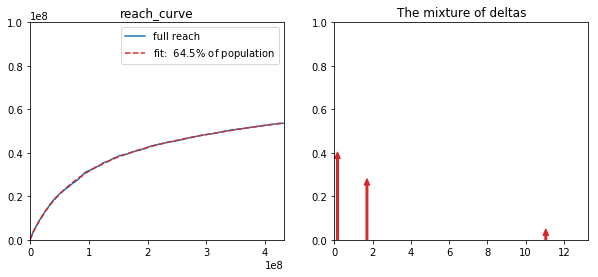

In [5]:
# Calculation of the population size from the `df_census` dataframe
df_census = spark.table("experian_census_5demos_counts")
population_size = df_census.agg(F.sum("population")).collect()[0][0]

# Performing the fit
alphas, rates = fit_mixture_of_deltas(df_reach_full_r1, n_deltas=3, population_size=population_size)
plot_reach_curve(df_reach_full_r1, population_size=population_size, alphas=alphas, rates=rates, plot_deltas=True)

# The uniform reach assumption
We can now assume the unifrom reach penetration into the demographic segments to produce a mixture-of-deltas for each separates demographic segment proportional to their size ratio to the total population size of universe. This is achieved by calling the `penetrate_uniform_reach(df_census, ...)` function. 

The total population of each segement is derived from the `df_census` table, which has demographic columns with a "population" column which is simply the count of the number of people in the demographic segment. 

In [6]:
#demo_cols = ["gender", "age_range"]
demo_cols = ["age_range"]

df_dirac_mixtures = penetrate_uniform_reach(df_census, alphas=alphas, rates=rates, demo_cols=demo_cols)

df_dirac_mixtures.head(10)

,age_range,ratio,alphas,rates
0,18_24,0.085747,"[0.03205658, 0.02156067, 0.00171384]","[0.15865175, 1.70040119, 11.05366013]"
1,25_34,0.265154,"[0.09912876, 0.06667221, 0.00529971]","[0.15865175, 1.70040119, 11.05366013]"
2,35_44,0.143781,"[0.05375284, 0.03615318, 0.00287378]","[0.15865175, 1.70040119, 11.05366013]"
3,45_54,0.133648,"[0.04996452, 0.03360523, 0.00267125]","[0.15865175, 1.70040119, 11.05366013]"
4,55_64,0.141567,"[0.05292525, 0.03559656, 0.00282954]","[0.15865175, 1.70040119, 11.05366013]"
5,65_74,0.098197,"[0.03671109, 0.02469121, 0.00196268]","[0.15865175, 1.70040119, 11.05366013]"
6,75_84,0.086869,"[0.03247639, 0.02184303, 0.00173628]","[0.15865175, 1.70040119, 11.05366013]"
7,85_120,0.045038,"[0.01683743, 0.01132455, 0.00090018]","[0.15865175, 1.70040119, 11.05366013]"


# Generating the VID assignment table
The first step in the VID assignement procedure is to generate the buckets/ranges/sets of VID associated with each delta (population pool). This size of each VID bucket is proportional to the amplitude of the delta functions and the rates of cookie generation (impression receival) for each demographic segment.

The function `generate_vid_assignment_table` creates a table with the probability ranges for each VID bucket in the two columns "prob_<=" and "prob_>" as well as the VID range in the columns "start_VID" and "total_VID".

In [20]:
vid_assignment_table = spark.createDataFrame(
    generate_vid_assignment_table(df_dirac_mixtures, demo_cols=demo_cols, 
                                  population_size=population_size, normalize=False)
)

vid_assignment_table.show()

,age_range,prob_>=,prob_<,alpha,rate,start_VID,total_VID
0,18_24,0.000000,0.083798,0.032057,0.158652,1,4032330
1,18_24,0.083798,0.687862,0.021561,1.700401,4032331,2712072
2,18_24,0.687862,1.000000,0.001714,11.053660,6744403,215581
3,25_34,0.000000,0.083798,0.099129,0.158652,6959984,12469197
4,25_34,0.083798,0.687863,0.066672,1.700401,19429181,8386557
5,25_34,0.687863,1.000000,0.005300,11.053660,27815738,666640
6,35_44,0.000000,0.083798,0.053753,0.158652,28482378,6761456
7,35_44,0.083798,0.687863,0.036153,1.700401,35243834,4547632
8,35_44,0.687863,1.000000,0.002874,11.053660,39791466,361487
9,45_54,0.000000,0.083798,0.049965,0.158652,40152953,6284932


# Assign the VIDs to each impression (weighted) for demographic segments
We now use a deterministic hash function on the `user_id` as a source of probability to determine the VID bucket from the `vid_assignment_table` and select any VID from that bucket uniformly (using another deterministic uniform hash function). The assignment is done by calling the function `assign_vids(df_impression, vid_assignment_table, demo_cols)` if the `mode="weighted"` is called then `n` number of VIDs are assigned to each `user_id`, where `n` is the (rounded) weight associated to that user.

In [8]:
df_reach_demo_r1 = generate_reach_table(df_impressions_exploded_r1, demo_cols=demo_cols, mode="count")
df_reach_demo_r2 = generate_reach_table(df_impressions_exploded_r2, demo_cols=demo_cols, mode="count")

df_vid_impressions_r1 = assign_vids(df_impressions_exploded_r1, vid_assignment_table,
                                    population_size=population_size, demo_cols=demo_cols, mode="uid_time")

df_vid_reach_demo_r1 = generate_reach_table(df_vid_impressions_r1, id_col="vid", 
                                            demo_cols=demo_cols, mode="count")

df_vid_reach_demo_r1.show()

,age_range,timestamp,reach_inc,impression_inc,reach,impression
0,18_24,2020-03-23 04:15:44,6,6,6,6
1,25_34,2020-03-23 04:19:07,60,60,60,300
2,85_120,2020-03-23 04:19:07,6,6,6,300
3,35_44,2020-03-23 04:19:07,34,34,34,300
4,45_54,2020-03-23 04:19:07,22,22,22,300
5,55_64,2020-03-23 04:19:07,171,171,171,300
6,65_74,2020-03-23 04:19:07,1,1,1,300
7,25_34,2020-03-23 04:22:08,18,18,78,324
8,18_24,2020-03-23 04:22:08,6,6,12,324
9,18_24,2020-03-23 05:07:07,6,6,18,330


# Plotting the VID count reach, actual report reach, and fit function
To get a better sense of the result, here we plot the VID counts, that are the estimated reach as outcomes of the algorithm and compare with the actual reports from the report as well as including the mixture of delta function in each of the demographic segments.

Note that the VID count still ends up on top of the report reach curve even though the fit curve penetrates each segment differently. This is because the impression count prenetration is based on the original demographic counts.

Text(0.5,0.98,'Illustration of the uniform reach problem (age_range demogrphic)')

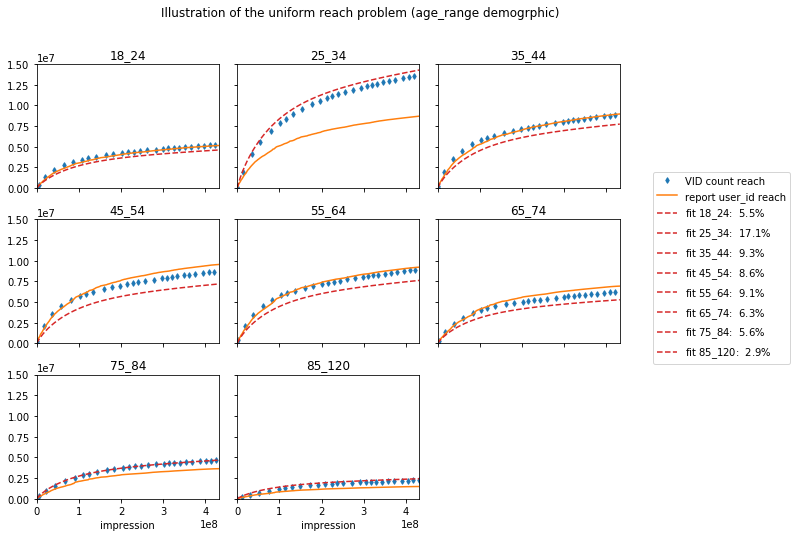

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(12,8), sharex=True, sharey=True)
plt.subplots_adjust(right=0.8, wspace=0.1, hspace=0.25)
axs = [ax for row in axs for ax in row]
handles, labels = [], []

jump = 100
for i, (label, df) in enumerate(df_vid_reach_demo_r1.toPandas().groupby(demo_cols)):
    df.iloc[::jump, :].plot(x="impression", y="reach", 
                            ax=axs[i], label=f"VID count reach", style="d", ms=4)

n = 2
fits = df_dirac_mixtures.sort_values(by=demo_cols)[["alphas", "rates"]]
#print(fits)
for i, (label, df) in enumerate(df_reach_demo_r1.toPandas().groupby(demo_cols)):
    alphas = fits["alphas"].loc[i]
    rates = fits["rates"].loc[i]
    df.plot(x="impression", y="reach", ax=axs[i], label=f"report user_id reach")


    axs[i].set_title(f"{label}")
    axs[i].set_ylim(0, 1.5e7)
    
    data = df[["impression", "reach"]].to_numpy()
    data = np.vstack([[0, 0], data])
    
    axs[i].plot(data[:, 0], delta_mixture_reach(data[:, 0]/population_size, *alphas, *rates)*population_size, 
                'C3--', label = f"fit {label}:  ${100*np.around(np.sum(alphas), 3):.1f}\%$")
    hs, ls = axs[i].get_legend_handles_labels()
    handles.append(hs[-1])
    labels.append(ls[-1])
    axs[i].legend().remove()

for i in range(8,9):
    axs[i].axis('off')
    
handles = hs[:2] + handles
labels  = ls[:2] + labels
fig.legend(handles, labels, loc="center right")
fig.suptitle("Illustration of the uniform reach problem (age_range demogrphic)")
#fig.savefig("uniform_reach_comparison_age_range.pdf")

# Frequency distribution of VID counts vs user_id impression records
The fit for the unique person reach is not perfect, but has reasonable accuracy. Let us now calculate the frequency inside each demographic segment.

The frequency plots indicate the TV/Linear problem of algebraic tail of frequencies. The tail seems to be present in a demographic segments.

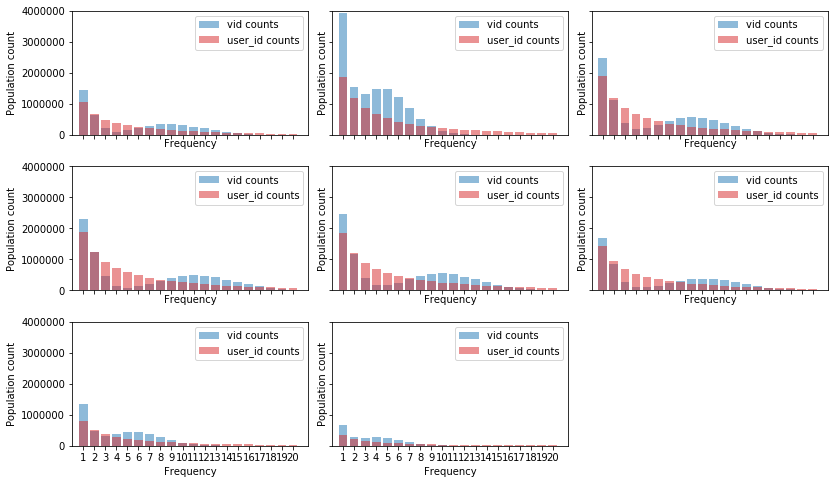

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(12,8), sharex=True, sharey=True)
plt.subplots_adjust(right=1.0, wspace=0.1, hspace=0.25)
axs = [ax for row in axs for ax in row]
handles, labels = [], []

df_vid_frequency_r1 = generate_frequency_table(df_vid_impressions_r1, id_col="vid", demo_cols=demo_cols)
df_frequency_r1 = generate_frequency_table(df_impressions_exploded_r1, id_col="user_id", demo_cols=demo_cols)

for i, (label, df) in enumerate(df_vid_frequency_r1.toPandas().groupby(demo_cols)):
    df = spark.createDataFrame(df)
    plot_frequency(df, axes=axs[i], id_col="vid", color='C0')

for i, (label, df) in enumerate(df_frequency_r1.toPandas().groupby(demo_cols)):
    df = spark.createDataFrame(df)
    plot_frequency(df, axes=axs[i], id_col="user_id", color='C3')

    axs[i].set_ylim(0, 4.0e6)

for i in range(8,9):
    axs[i].axis('off')

# In-segment reach curve fitting
Instead of assuming the uniform reach into each of the segments, we can fit a separate mixture of deltas inside each of the demographic segments. And use those to assign the VIDs. This should fix the off estimation of uniform reach VID assignment, for example for the "25_35" age group above. 

18_24 : [verbose] alphas :  [0.0305 0.018  0.0048], rates  :  [0.2662 1.7447 5.909 ]
25_34 : [verbose] alphas :  [0.0539 0.0314 0.0065], rates  :  [0.255  1.8201 6.8009]
35_44 : [verbose] alphas :  [0.0529 0.0312 0.0068], rates  :  [0.291  1.8719 6.8082]
45_54 : [verbose] alphas :  [0.0535 0.0402 0.005 ], rates  :  [0.2523 1.8225 9.0703]
55_64 : [verbose] alphas :  [0.0728 0.0466 0.0023], rates  :  [ 0.1215  1.7088 15.2472]
65_74 : [verbose] alphas :  [0.     0.     0.0548], rates  :  [0.     0.     1.0863]
75_84 : [verbose] alphas :  [0.    0.    0.029], rates  :  [0.     0.     1.0129]
85_120 : [verbose] alphas :  [0.     0.     0.0119], rates  :  [0.     0.     0.9773]


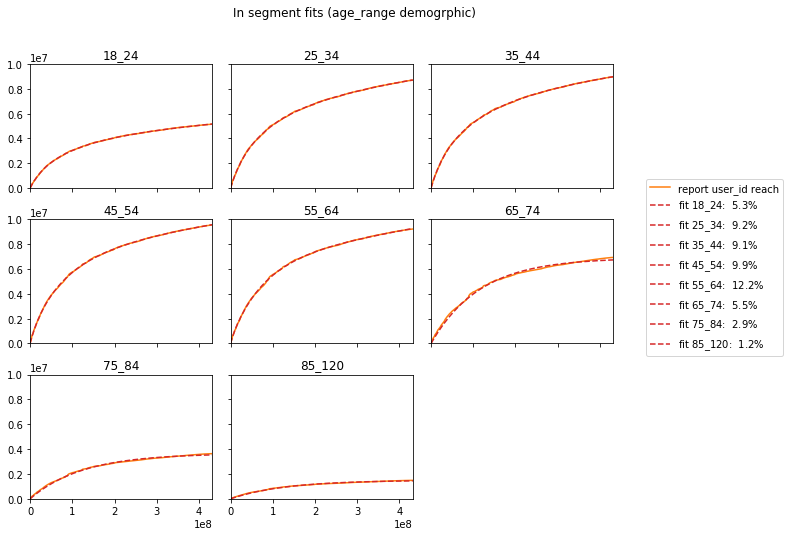

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(12,8), sharex=True, sharey=True)
plt.subplots_adjust(right=0.8, wspace=0.1, hspace=0.25)
axs = [ax for row in axs for ax in row]
handles, labels = [], []

previous_vid = 0
dp_dirac_mixtures = pd.DataFrame(columns=[*demo_cols, "alphas", "rates"])

for i, (label, df) in enumerate(df_reach_demo_r1.toPandas().groupby(*demo_cols)):
    
    data = df[["impression", "reach"]].to_numpy()
    data = np.vstack([[0, 0], data])
    print(label, end=" : ")
    alphas, rates = vid_spark._fit_mixture_of_deltas(data/population_size, 3, verbose=True)
    
    dp_dirac_mixtures.loc[i] = [label, alphas, rates]

    axs[i].plot(data[:, 0], data[:, 1], color='C1', label=f"report user_id reach")
    axs[i].set_title(f"{label}")
    axs[i].set_ylim(0, 1.0e7)
    axs[i].set_xlim(0, max(data[:, 0]))
    axs[i].plot(data[:, 0], delta_mixture_reach(data[:, 0]/population_size, *alphas, *rates)*population_size,
                'C3--', label = f"fit {label}:  ${100*np.around(np.sum(alphas), 3):.1f}\%$")
    
    hs, ls = axs[i].get_legend_handles_labels()
    handles.append(hs[-1])
    labels.append(ls[-1])
    axs[i].legend().remove()

for i in range(8,9):
    axs[i].axis('off')

handles = hs[:1] + handles
labels = ls[:1] + labels
fig.legend(handles, labels, loc="center right")

fig.suptitle("In segment fits (age_range demogrphic)")

#df_dirac_mixtures = spark.createDataFrame(dp_dirac_mixtures)
#df_dirac_mixtures.show(12)
df_dirac_mixtures_segmented = dp_dirac_mixtures

In [12]:
# Vid assignement table
vid_assignment_table = spark.createDataFrame(
    generate_vid_assignment_table(df_dirac_mixtures_segmented, demo_cols=demo_cols, population_size=population_size)
)

vid_assignment_table.show()

,age_range,prob_>=,prob_<,alpha,rate,start_VID,total_VID
0,18_24,0.000000,0.119538,0.030483,0.266248,1,3834422
1,18_24,0.119538,0.583067,0.018039,1.744666,3834423,2269052
2,18_24,0.583067,1.000000,0.004791,5.909016,6103475,602602
3,25_34,0.000000,0.119581,0.053946,0.254985,6706077,6785803
4,25_34,0.119581,0.615848,0.031364,1.820131,13491880,3945183
5,25_34,0.615848,1.000000,0.006498,6.800919,17437063,817315
6,35_44,0.000000,0.128361,0.052902,0.290989,18254378,6654480
7,35_44,0.128361,0.615916,0.031236,1.871923,24908858,3929106
8,35_44,0.615916,1.000000,0.006766,6.808198,28837964,851046
9,45_54,0.000000,0.102278,0.053455,0.252328,29689010,6723966


# Comparison of mixture-of-deltas distributions 
The in-segment reach curve fitting result in perfect learning of the reach curves. While the uniform reach assumption did not. Let us compare them in the space of dirac deltas amplitudes vs the rates of generation. 

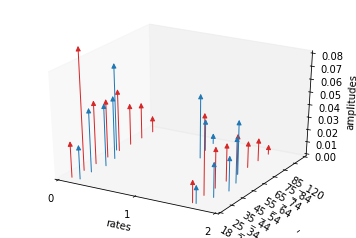

In [13]:
fig, ax = dirac_mixtures_plot_3d_segment(df_dirac_mixtures, demo_cols=demo_cols)
fig, ax = dirac_mixtures_plot_3d_segment(df_dirac_mixtures_segmented, demo_cols=demo_cols, ax=ax, color='C0')
fig.savefig("dirac_deltas_penetration-vs-insegment.pdf")

# VID assignment, reach, and frequency for in-segment
Let us do the same process now for the in-segment fits.

In [14]:
vid_assignment_table = spark.createDataFrame(
    generate_vid_assignment_table(df_dirac_mixtures_segmented, demo_cols=demo_cols, population_size=population_size)
)

vid_assignment_table.show()

,age_range,prob_>=,prob_<,alpha,rate,start_VID,total_VID
0,18_24,0.000000,0.119538,0.030483,0.266248,1,3834422
1,18_24,0.119538,0.583067,0.018039,1.744666,3834423,2269052
2,18_24,0.583067,1.000000,0.004791,5.909016,6103475,602602
3,25_34,0.000000,0.119581,0.053946,0.254985,6706077,6785803
4,25_34,0.119581,0.615848,0.031364,1.820131,13491880,3945183
5,25_34,0.615848,1.000000,0.006498,6.800919,17437063,817315
6,35_44,0.000000,0.128361,0.052902,0.290989,18254378,6654480
7,35_44,0.128361,0.615916,0.031236,1.871923,24908858,3929106
8,35_44,0.615916,1.000000,0.006766,6.808198,28837964,851046
9,45_54,0.000000,0.102278,0.053455,0.252328,29689010,6723966


In [15]:
df_vid_impressions_r1 = assign_vids(df_impressions_exploded_r1, vid_assignment_table,
                                    population_size=population_size, demo_cols=demo_cols, mode="uid_time")

df_vid_reach_demo_r1 = generate_reach_table(df_vid_impressions_r1, id_col="vid", 
                                            demo_cols=demo_cols, mode="count")

df_vid_reach_demo_r1.show()

,age_range,timestamp,reach_inc,impression_inc,reach,impression
0,18_24,2020-03-23 04:15:44,6,6,6,6
1,35_44,2020-03-23 04:19:07,34,34,34,300
2,45_54,2020-03-23 04:19:07,22,22,22,300
3,55_64,2020-03-23 04:19:07,171,171,171,300
4,85_120,2020-03-23 04:19:07,6,6,6,300
5,25_34,2020-03-23 04:19:07,60,60,60,300
6,65_74,2020-03-23 04:19:07,1,1,1,300
7,18_24,2020-03-23 04:22:08,6,6,12,324
8,25_34,2020-03-23 04:22:08,18,18,78,324
9,18_24,2020-03-23 05:07:07,6,6,18,330


Text(0.5,0.98,'Illustration of in-segment reach curve fits (age_range demogrphic)')

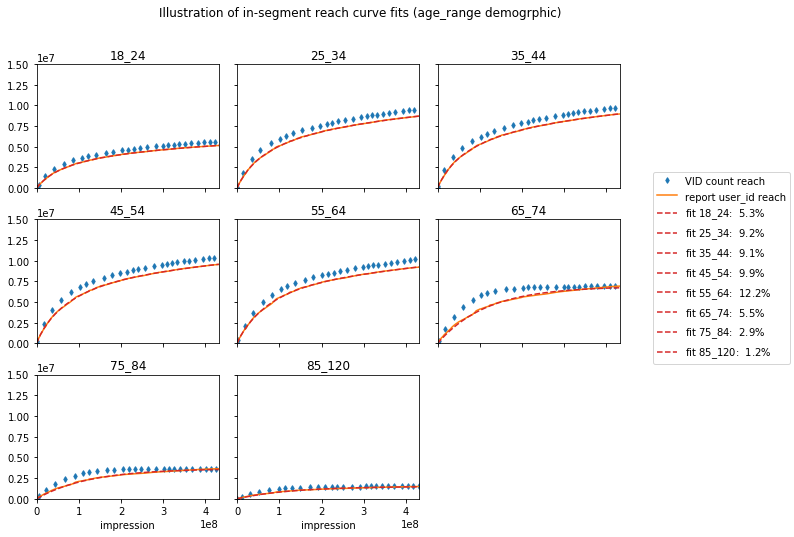

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(12,8), sharex=True, sharey=True)
plt.subplots_adjust(right=0.8, wspace=0.1, hspace=0.25)
axs = [ax for row in axs for ax in row]
handles, labels = [], []

jump = 100
for i, (label, df) in enumerate(df_vid_reach_demo_r1.toPandas().groupby(demo_cols)):
    df.iloc[::jump, :].plot(x="impression", y="reach", 
                            ax=axs[i], label=f"VID count reach", style="d", ms=4)

n = 2
fits = df_dirac_mixtures_segmented.sort_values(by=demo_cols)[["alphas", "rates"]]
#print(fits)
for i, (label, df) in enumerate(df_reach_demo_r1.toPandas().groupby(demo_cols)):
    alphas = fits["alphas"].loc[i]
    rates = fits["rates"].loc[i]
    df.plot(x="impression", y="reach", ax=axs[i], label=f"report user_id reach")


    axs[i].set_title(f"{label}")
    axs[i].set_ylim(0, 1.5e7)
    
    data = df[["impression", "reach"]].to_numpy()
    data = np.vstack([[0, 0], data])
    
    axs[i].plot(data[:, 0], delta_mixture_reach(data[:, 0]/population_size, *alphas, *rates)*population_size, 
                'C3--', label = f"fit {label}:  ${100*np.around(np.sum(alphas), 3):.1f}\%$")
    hs, ls = axs[i].get_legend_handles_labels()
    handles.append(hs[-1])
    labels.append(ls[-1])
    axs[i].legend().remove()

for i in range(8,9):
    axs[i].axis('off')
    
handles = hs[:2] + handles
labels  = ls[:2] + labels
fig.legend(handles, labels, loc="center right")
fig.suptitle("Illustration of in-segment reach curve fits (age_range demogrphic)")
#fig.savefig("uniform_reach_comparison_age_range.pdf")

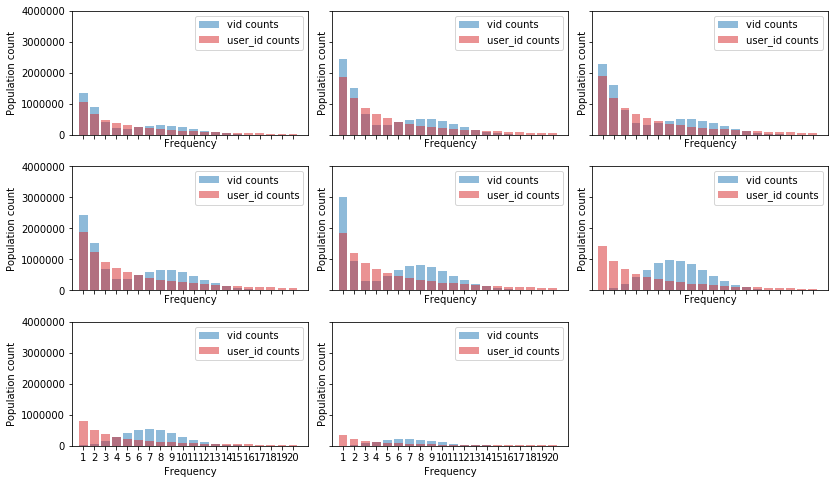

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(12,8), sharex=True, sharey=True)
plt.subplots_adjust(right=1.0, wspace=0.1, hspace=0.25)
axs = [ax for row in axs for ax in row]
handles, labels = [], []

df_vid_frequency_r1 = generate_frequency_table(df_vid_impressions_r1, id_col="vid", demo_cols=demo_cols)
#df_frequency_r1 = generate_frequency_table(df_impressions_exploded_r1, id_col="user_id", demo_cols=demo_cols)

for i, (label, df) in enumerate(df_vid_frequency_r1.toPandas().groupby(demo_cols)):
    df = spark.createDataFrame(df)
    plot_frequency(df, axes=axs[i], id_col="vid", color='C0')

for i, (label, df) in enumerate(df_frequency_r1.toPandas().groupby(demo_cols)):
    df = spark.createDataFrame(df)
    plot_frequency(df, axes=axs[i], id_col="user_id", color='C3')

    axs[i].set_ylim(0, 4.0e6)

for i in range(8,9):
    axs[i].axis('off')